Mini-Project!
Statistical Modeling and Interpretation of Results in Churn Analysis!

In [1]:
!pip install -q -U watermark

In [2]:
!pip install -q pandas==2.3.1 numpy==2.3.2 statsmodels==0.14.4 seaborn==0.13.2 matplotlib==3.8.0 plotly==5.24.1 ipython==8.30.0


ERROR: Cannot install matplotlib==3.8.0, numpy==2.3.2, pandas==2.3.1, seaborn==0.13.2 and statsmodels==0.14.4 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, Markdown

In [4]:
#config to better display the data
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [5]:
%reload_ext watermark
%watermark -a "Eduardo" -a "Data Engineer" -a "2025-10-20" -a "Mini-Project" -a "Statistical Modeling and Interpretation of Results in Churn Analysis"

Author: Statistical Modeling and Interpretation of Results in Churn Analysis



In [6]:
%watermark --iversions

IPython    : 8.30.0
seaborn    : 0.13.2
matplotlib : 3.8.4
numpy      : 1.26.4
pandas     : 2.3.1
plotly     : 5.24.1
statsmodels: 0.14.4



display(Markdown("""
## 2. Business Problem Definition

### **2.1. Business Problem**

**Conecta Telecom**, a fictitious telecommunications company, is facing a churn rate above the industry average.

Management needs clear, data-driven answers to the following question:
**What are the main factors that lead our customers to cancel their services?**

- We want to understand the relationship between variables → Statistical Modeling
- If we want to predict churn → Predictive Modeling

### **2.2. Project Objectives**

This project aims to use statistical modeling to analyze customer data and achieve the following objectives:

1. Identify Key Factors: Determine which variables (such as contract type, loyalty period, invoice amount) have a direct impact on churn.
2. Quantify the Impact: Measure the influence of each factor on churn risk.
3. Generate Recommendations: Translate the results of the statistical analysis into actionable business recommendations for creating customer retention strategies.

The model chosen for this analysis will be Logistic Regression, as our goal is to understand the relationship between several variables and a binary variable (churn or no churn).
"""))

In [7]:
def dsa_generate_churn_data(num_clients=2000):
    """
    Generates a DataFrame of fictitious customer data from a telecommunications company.
    """

    # For reproducibility
    np.random.seed(42)

    # Variables
    tenure_months = np.random.randint(1, 73, size=num_clients)

    contract_type_opts = ['Monthly', 'Annual', 'Two years']
    contract_probs = [0.6, 0.25, 0.15]
    contract_type = np.random.choice(contract_type_opts, size=num_clients, p=contract_probs)

    internet_service_opts = ['Fiber Optics', 'DSL', 'No']
    internet_probs = [0.55, 0.35, 0.10]
    internet_service = np.random.choice(internet_service_opts, size=num_clients, p=internet_probs)

    base_charge = {
        'Monthly': np.random.normal(60, 20),
        'Annual': np.random.normal(70, 25),
        'Two years': np.random.normal(80, 25)
    }

    monthly_charge = [
        base_charge[c] + tenure_months[i] * 0.2 + np.random.normal(0, 5)
        for i, c in enumerate(contract_type)
    ]
    monthly_charge = np.clip(monthly_charge, 20, 120)

    # Logic for churn probability
    prob_churn_log = -2.5
    prob_churn_log += -0.05 * tenure_months  # More loyalty, less chance of churn
    prob_churn_log += [3.0 if c == 'Monthly' else 1.5 if c == 'Annual' else 0 for c in contract_type]
    prob_churn_log += [0.8 if s == 'Fiber Optics' else -0.5 if s == 'DSL' else 0 for s in internet_service]
    prob_churn_log += 0.03 * np.array(monthly_charge)  # Higher bills, more chance of churn

    prob_churn = 1 / (1 + np.exp(-np.array(prob_churn_log)))
    churn = np.random.binomial(1, prob_churn)

    # Construct DataFrame
    df = pd.DataFrame({
        'CustomerID': range(1, num_clients + 1),
        'TenureMonths': tenure_months,
        'ContractType': contract_type,
        'InternetService': internet_service,
        'MonthlyCharge': monthly_charge,
        'Churn': churn
    })

    return df


In [8]:
# Generate data
df_churn = dsa_generate_churn_data()

In [9]:
display(Markdown("### Sample of Generated Data"))
display(df_churn.head())


### Sample of Generated Data

,CustomerID,TenureMonths,ContractType,InternetService,MonthlyCharge,Churn
0,1,52,Annual,Fiber Optics,36.5724,0
1,2,15,Two years,Fiber Optics,45.2871,0
2,3,72,Monthly,Fiber Optics,101.0033,1
3,4,61,Monthly,Fiber Optics,103.3314,1
4,5,21,Monthly,DSL,94.0969,1


## 4. Exploratory Data  (EDA)

In [10]:
# General dataframe information
display(Markdown("### General dataframe information"))
df_churn.info()


### General dataframe information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       2000 non-null   int64  
 1   TenureMonths     2000 non-null   int64  
 2   ContractType     2000 non-null   object 
 3   InternetService  2000 non-null   object 
 4   MonthlyCharge    2000 non-null   float64
 5   Churn            2000 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 93.9+ KB


In [11]:
# Summary Statistical  of Numerical Variables
display(Markdown("### Statistical Summary of Numerical Variables"))
display(df_churn.describe())


### Statistical Summary of Numerical Variables

,CustomerID,TenureMonths,MonthlyCharge,Churn
count,2000.0000,2000.0000,2000.0000,2000.0000
mean,1000.5000,35.6825,75.3201,0.5655
std,577.4946,20.8430,27.5079,0.4958
min,1.0000,1.0000,24.9216,0.0000
25%,500.7500,17.0000,45.0201,0.0000
50%,1000.5000,35.0000,90.6543,1.0000
75%,1500.2500,54.0000,98.5286,1.0000
max,2000.0000,72.0000,119.2712,1.0000


## 4.1 Summary Statistics of Categorical Variables

In [12]:
# Summary Statistics of Categorical Variables
display(Markdown("### Summary Statistics of Categorical Variables"))
display(df_churn.describe(include=['object']))


### Summary Statistics of Categorical Variables

,ContractType,InternetService
count,2000,2000
unique,3,3
top,Monthly,Fiber Optics
freq,1186,1114


## 4.2 Overall Churn Rate Chart

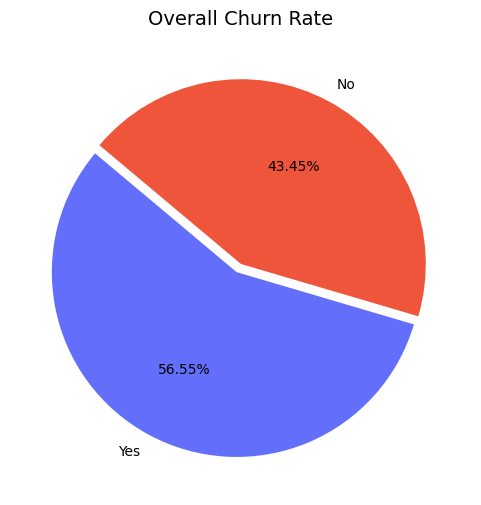

In [13]:
# Counts the values ​​in the 'Churn' column
churn_counts = df_churn['Churn'].value_counts().rename(index={1: 'Yes', 0: 'No'})

# Sets the colors equivalent to the original graph
colors = ['#636EFA', '#EF553B']

# Creates the pie chart with two decimal places
plt.figure(figsize=(6, 6))
plt.pie(
    churn_counts.values,
    labels=churn_counts.index,
    autopct='%1.2f%%',          # show percentage with 2 decimal places
    startangle=140,             # initial angle to rotate the graph
    colors=colors,
    explode=[0.05 if label == 'Yes' else 0 for label in churn_counts.index]  # highlights the "Yes" slice
)
plt.title('Overall Churn Rate', fontsize=14)
plt.show()


In [ ]:
import plotly.io as pio
pio.renderers.default = "browser"  


In [15]:
# Calculate count by category
churn_counts = df_churn['Churn'].value_counts()

# Create the graph
fig_pie = px.pie(
    values=churn_counts.values,
    names=churn_counts.index.map({1: 'Yes', 0: 'No'}),  # rename the categories
    title='Overall Churn Rate',
    color=churn_counts.index.map({1: 'Yes', 0: 'No'}),  # use the same categories for color
    color_discrete_map={'Yes': '#EF553B', 'No': '#636EFA'}  # define manual colors
)

# Show the chart
fig_pie.show()


In [16]:
# Calculate the churn rate
churn_counts = df_churn['Churn'].value_counts()
numerador = churn_counts.get(1, churn_counts.get('Yes', churn_counts.get(True, 0)))
taxa = 100 * numerador / len(df_churn) 

display(Markdown(f"""
The average churn rate in our database is {taxa: 2f}%.
This is our main indicator to analyze.
"""))


The average churn rate in our database is  56.550000%.
This is our main indicator to analyze.


## 4.3 Graph by Churn Rate by Type of Contract

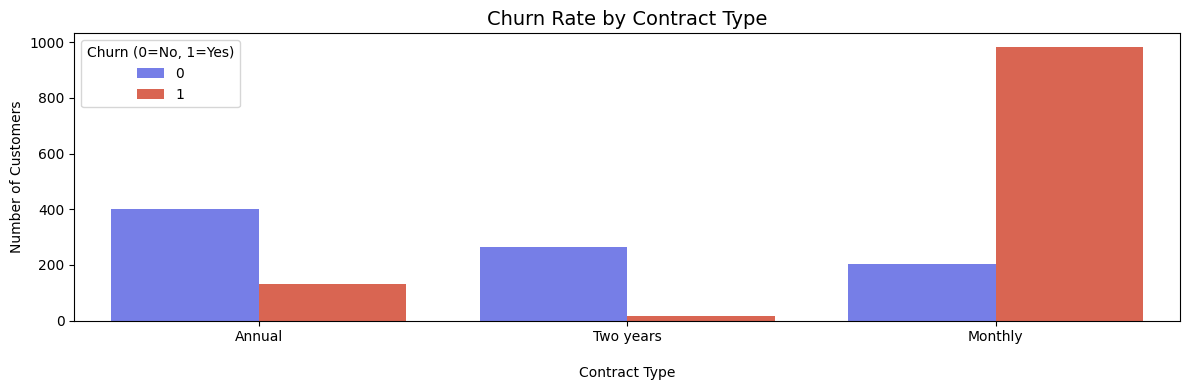

In [19]:
# Graphic -- static version
plt.figure(figsize=(12, 4))

# Creates the grouped bar chart with Seaborn
sns.countplot(data=df_churn,
              x='ContractType',
              hue='Churn',
              palette={0: '#636EFA', 1: '#EF553B'})

plt.title('Churn Rate by Contract Type', fontsize=14)
plt.xlabel('\nContract Type')
plt.ylabel('Number of Customers')
plt.legend(title='Churn (0=No, 1=Yes)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



# The chance to a monthly contract churn is bigger than the other two.

In [20]:
# Graphic – Interactive Version

# Histogram
fig_bar_contract = px.histogram(df_churn,
                                x='ContractType',
                                color='Churn',
                                barmode='group',
                                title='Churn Rate by Contract Type',
                                labels={'ContractType': 'Contract Type','Churn': 'Churn (0=No, 1=Yes)'})
fig_bar_contract.show()


display(Markdown("""
**Insight:** The visualization is clear: customers with **monthly contracts** have a drastically higher churn tendency compared to customers with longer contracts.
"""))


## 4.4 Interactive Plotly Chart (Tenure vs Churn)

In [ ]:
# Graphic – Interactive Version

# Analysis by Tenure (Loyalty)
fig_hist_tenure = px.histogram(df_churn,
                                x='TenureMonths',
                                color='Churn',
                                marginal='box',
                                title='Tenure (in Months) Distribution by Churn',
                                labels={'TenureMonths': 'Tenure (Months)', 'Churn': 'Churn (0=No, 1=Yes)'})

fig_hist_tenure.show()
